In [1]:
import os
import sys
import datetime
import tensorflow as tf
import numpy as np
import cirq
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import pickle as pkl

from encode_state import EncodeState
from leakage import LeakageModels
from input_circuits import InputCircuits
from loss import DiscriminationLoss
from noise.noise_model import TwoQubitNoiseModel, two_qubit_depolarize

In this notebook we will use the qutrit model and the normal model to compare preformance on the
state discrimination task.
So, this requires 4 qubits in the vanilla model, and 6 qubits in the leaky model.

In [2]:
local_save = '../training_out/compare_models'
dt_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
checkpoint_path = os.path.join(local_save, dt_time)


In [4]:
n = 4
mu = 0.75
circuits = InputCircuits(n)
train_circuits, train_labels, test_circuits, test_labels = circuits.create_discrimination_circuits(mu_a=0.9)
encoder = EncodeState(n)
leakage = LeakageModels(4, 2, True, 0)
noise_model = TwoQubitNoiseModel(cirq.depolarize(0.01), two_qubit_depolarize(0.01))
noisy_sim = cirq.DensityMatrixSimulator(noise=noise_model)

In [5]:
discrimination_model = encoder.discrimination_model()
leakage_model = leakage.leaky_model()
noisy_model = encoder.discrimination_model(backend=noisy_sim)

discrimination_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'discrimination', 'discrimination.ckpt'),
    verbose = 1,
    save_weights_only=True)
leakage_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'leakage', 'leakage.ckpt'),
    verbose = 1,
    save_weights_only=True)
noisy_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'noisy', 'noisy.ckpt'),
    verbose = 1,
    save_weights_only=True)

In [6]:
loss = DiscriminationLoss(0.5, 0.5)
loss_fn = loss.discrimination_loss
discrimination_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                             loss = loss_fn,
                             metrics=['accuracy'])
leakage_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                      loss = loss_fn,
                      metrics=['accuracy'])
noisy_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    loss = loss_fn,
                    metrics=['accuracy'])

Run these next three cells if you want to train a new model:

In [36]:
leakage_history = leakage_model.fit(
                        x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=10,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[leakage_callback])
with open(os.path.join(checkpoint_path, 'leakage', 'history.pkl'), 'wb') as f:
    pkl.dump(leakage_history.history, f)
with open(os.path.join(checkpoint_path, 'leakage', 'params.pkl'), 'wb') as f:
    pkl.dump(leakage_history.params, f)

Train on 700 samples, validate on 300 samples
Epoch 1/10
690/700 [============================>.] - ETA: 0s - loss: 0.2817 - accuracy: 0.4536      

In [44]:
discrimination_history = discrimination_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=10,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[discrimination_callback])

with open(os.path.join(checkpoint_path, 'discrimination', 'history.pkl'), 'wb') as f:
    pkl.dump(discrimination_history.history, f)
with open(os.path.join(checkpoint_path, 'discrimination', 'params.pkl'), 'wb') as f:
    pkl.dump(discrimination_history.params, f)

Train on 700 samples, validate on 300 samples
Epoch 1/10
690/700 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.5087  

In [6]:
noisy_history = noisy_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=10,
                        verbose=1,
                        validation_data=(test_circuits, test_labels),
                        callbacks=[noisy_callback])
with open(os.path.join(checkpoint_path, 'noisy', 'history.pkl'), 'wb') as f:
    pkl.dump(noisy_history.history, f)
with open(os.path.join(checkpoint_path, 'noisy', 'params.pkl'), 'wb') as f:
    pkl.dump(noisy_history.params, f)

Train on 700 samples, validate on 300 samples
Epoch 1/10
690/700 [============================>.] - ETA: 10s - loss: 0.2688 - accuracy: 0.5884  

Run this next cell if you'd rather load a pre-trained model:

In [9]:
save_point = sorted(os.listdir(local_save),
                     key=lambda x: datetime.datetime.strptime(x, '%Y_%m_%d_%H_%M_%S'))[-1]

models_dict = {}
models = [
    (leakage_model, 'leakage'),
    (discrimination_model, 'discrimination'),
    (noisy_model, 'noisy')
]
for model, folder in models:
    models_dict[folder] = {}
    models_dict[folder]['model'] = model
    path = os.path.join(local_save, save_point, folder)
    model.load_weights(os.path.join(path,  folder + '.ckpt'))
    # loss, acc = model.evaluate([test_circuits], [test_labels], verbose=1)
    # models_dict[folder]['loss'] = loss
    # models_dict[folder]['accuracy'] = acc
    with open(os.path.join(path, 'history.pkl'), 'rb') as f:
        models_dict[folder]['history'] = pkl.load(f)
    with open(os.path.join(path, 'params.pkl'), 'rb') as f:
        models_dict[folder]['params'] = pkl.load(f)

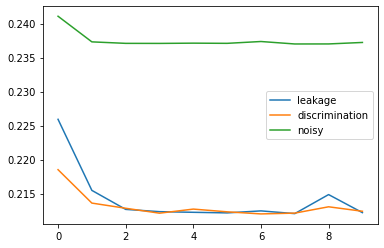

In [10]:
fig, ax = plt.subplots()
for model in models_dict.keys():
    ax.plot(models_dict[model]['history']['val_loss'], label=model)
plt.legend()

